# ESM2 fine-tuning with LoRA/QLoRA for Antimicrobial Peptides (AMP) Classification

## Overview
This notebook demonstrates the process of:
1. Fine-tuning ESM2 models with Low-Rank Adaptation (LoRA) or Quantized Low-Rank Adaptation (QLoRA) to perform AMP classification (AMP vs non-AMP ).
2. Evaluating the model's performance using metrics such as accuracy, precision, recall, F1-score, ROC AUC, and Matthews correlation coefficient (MCC).

In [ ]:
# Install dependencies

!pip install datasets wandb transformers peft biopython accelerate>=0.21.0 bitsandbytes

In [ ]:
# Import necessary libraries

import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, EsmForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig
from Bio import SeqIO
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType, LoftQConfig, get_peft_config, PeftModel, PeftConfig, TaskType, prepare_model_for_kbit_training
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, matthews_corrcoef
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType, LoftQConfig
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig
import gc
import wandb
import os
import argparse
import random

## Helper Functions for Data Loading and Preparation

In [ ]:
# Function to load sequences from a FASTA file
def load_fasta(file_path):
    """
    Load sequences from a FASTA file.

    Args:
        file_path (str): Path to the FASTA file.

    Returns:
        list: A list of sequences from the FASTA file.
    """
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

In [ ]:
def prepare_dataset(amp_fasta, non_amp_fasta):
    """
    Prepare datasets by loading sequences and generating labels.

    Args:
        amp_fasta (str): Path to the AMP FASTA file.
        non_amp_fasta (str): Path to the non-AMP FASTA file.

    Returns:
        tuple: A tuple containing:
            - sequences (list): List of sequences.
            - labels (list): Binary labels (1 for AMP, 0 for non-AMP).
    """
    amp_data = load_fasta(amp_fasta)
    non_amp_data = load_fasta(non_amp_fasta)
    sequences = amp_data + non_amp_data
    labels = [1] * len(amp_data) + [0] * len(non_amp_data)
    return sequences, labels

### Data Preparation
Loading and processing training, validation and test datasets.

In [ ]:
# File paths for training, validation, and test datasets
train_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_train_positive.fasta"
train_non_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_train_negative.fasta"

validation_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_val_positive.fasta"
validation_non_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_val_negative.fasta"

test_amp_fasta = "/path/to/your/folder/DRAMP_AMP.fasta"
test_non_amp_fasta = "/path/to/your/folder/DRAMP_nonAMP.fasta"

In [ ]:
# Prepare datasets

train_sequences, train_labels = prepare_dataset(train_amp_fasta, train_non_amp_fasta)
validation_sequences, validation_labels = prepare_dataset(val_amp_fasta, val_non_amp_fasta)
test_sequences, test_labels = prepare_dataset(test_amp_fasta, test_non_amp_fasta)

### ESM2 Model Selection and Loading
Select model and provide the shorthand to load_esm2_model function to load it. For QLoRA fine-tuning quantized model has to be loaded by defining "quantized=True" in load_esm2_model function.

In [ ]:
#@title ESM2 Model Versions Table

from IPython.core.display import HTML

html_table = """
<style>
    table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 80%;
        margin: auto;
        font-size: 16px;
    }
    th, td {
        border: 1px solid #dddddd;
        text-align: center;
        padding: 8px;
    }
    th {
        background-color: #f2f2f2;
        color: #333;
    }
    tr:nth-child(even) {
        background-color: #f9f9f9;
    }
    tr:hover {
        background-color: #f1f1f1;
    }
</style>
<table>
    <thead>
        <tr>
            <th>ESM-2 Model Version (Shorthand)</th>
            <th># Layers</th>
            <th># Params</th>
            <th>Embedding Dim</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>esm2_t48_15B_UR50D (t48)</td>
            <td>48</td>
            <td>15B</td>
            <td>5120</td>
        </tr>
        <tr>
            <td>esm2_t36_3B_UR50D (t36)</td>
            <td>36</td>
            <td>3B</td>
            <td>2560</td>
        </tr>
        <tr>
            <td>esm2_t33_650M_UR50D (t33)</td>
            <td>33</td>
            <td>650M</td>
            <td>1280</td>
        </tr>
        <tr>
            <td>esm2_t30_150M_UR50D (t30)</td>
            <td>30</td>
            <td>150M</td>
            <td>640</td>
        </tr>
        <tr>
            <td>esm2_t12_35M_UR50D (t12)</td>
            <td>12</td>
            <td>35M</td>
            <td>480</td>
        </tr>
        <tr>
            <td>esm2_t6_8M_UR50D (t6)</td>
            <td>6</td>
            <td>8M</td>
            <td>320</td>
        </tr>
    </tbody>
</table>
"""

display(HTML(html_table))




ESM-2 Model Version (Shorthand),# Layers,# Params,Embedding Dim
esm2_t48_15B_UR50D (t48),48,15B,5120
esm2_t36_3B_UR50D (t36),36,3B,2560
esm2_t33_650M_UR50D (t33),33,650M,1280
esm2_t30_150M_UR50D (t30),30,150M,640
esm2_t12_35M_UR50D (t12),12,35M,480
esm2_t6_8M_UR50D (t6),6,8M,320


In [ ]:
def load_esm2_model(shorthand, quantized=False):
    """
    Load a pretrained ESM-2 model and tokenizer based on its shorthand identifier,
    with an option to load the model in quantized mode for QLoRA.

    Args:
        shorthand (str): Model shorthand (e.g., 't12', 't33').
        quantized (bool): Whether to load the model with quantization. Default is False.

    Returns:
        model: Loaded ESM-2 model.
        tokenizer: Loaded tokenizer for the ESM-2 model.
    """

    # Define model versions
    model_versions = {
        "t48": "esm2_t48_15B_UR50D",
        "t36": "esm2_t36_3B_UR50D",
        "t33": "esm2_t33_650M_UR50D",
        "t30": "esm2_t30_150M_UR50D",
        "t12": "esm2_t12_35M_UR50D",
        "t6": "esm2_t6_8M_UR50D",
    }

    # Validate shorthand
    if shorthand not in model_versions:
        raise ValueError(f"Invalid model shorthand '{shorthand}'.")

    model_name = model_versions[shorthand]

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(f"facebook/{model_name}")

    if quantized:
        # Configure quantization
        bnb_config = BitsAndBytesConfig(
          load_in_4bit=True,
          bnb_4bit_use_double_quant=True,
          bnb_4bit_quant_type="nf4",
          llm_int8_skip_modules=["classifier", "pre_classifier"],
          bnb_4bit_compute_dtype=torch.bfloat16
          )
        # Load the quantized model
        model = EsmForSequenceClassification.from_pretrained(
            f"facebook/{model_name}",
            num_labels=2,
            quantization_config=bnb_config
        )
    else:
        # Load the regular model
        model = EsmForSequenceClassification.from_pretrained(f"facebook/{model_name}", num_labels=2)

    return model, tokenizer

# Choose model's shorthand
shorthand = "t6"

# Load the model
model, tokenizer = load_esm2_model(shorthand, quantized=False)


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Data Loading and Preperation

Load train/validation/test datasets, tokenize and prepare them for LoRA/QLoRA fine-tuning.

In [ ]:
def tokenize_and_create_dataset(sequences, labels, tokenizer, max_length=512):
    """
    Tokenize sequences and create a Dataset object.

    Args:
        sequences (list): List of sequences to tokenize.
        labels (list): List of labels corresponding to the sequences.
        tokenizer (AutoTokenizer): Pretrained tokenizer for the model.
        max_length (int): Maximum token length for sequences.

    Returns:
        Dataset: A Hugging Face Dataset object containing tokenized inputs and labels.
    """
    tokenized = tokenizer(
        sequences,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    return Dataset.from_dict({**tokenized, "labels": labels})

In [ ]:
# Tokenize and create Dataset object for each dataset

train_dataset = tokenize_and_create_dataset(train_sequences, train_labels, tokenizer)
validation_dataset = tokenize_and_create_dataset(validation_sequences, val_labels, tokenizer)
test_dataset = tokenize_and_create_dataset(test_sequences, test_labels, tokenizer)


## Training Configuration and LoRA/QLoRA Setup

In [ ]:
# Configure LoRA
lora_config = LoraConfig(
    task_type= TaskType.SEQ_CLS,
    inference_mode=False,
    r=1,
    lora_alpha=1.0,
    lora_dropout=0.1,
    bias="lora_only",
    target_modules=["query", "key", "value"]
)

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="output",
    learning_rate=0.001,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.1,
    fp16=True,
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define custom compute_metrics for the trainer

def compute_metrics(p):
    logits, true_labels = p
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

    # Calculate ROC AUC Score if possible
    roc_auc = roc_auc_score(true_labels, logits[:, 1]) if len(np.unique(true_labels)) == 2 else float('nan')

    # Calculate Matthews correlation coefficient
    mcc = matthews_corrcoef(true_labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,  # Add MCC to the returned metrics
        'roc_auc': roc_auc
    }

In [ ]:
# Function for random seed initialization

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Function to apply PEFT configuration for not quantized and quantized model

def apply_peft_model(model, lora_config):
    """
    Automatically checks if the model is quantized (e.g., uses Linear4bit layers)
    and applies PEFT configuration accordingly.

    Args:
        model: The base model to which PEFT will be applied.
        lora_config: Configuration for LoRA.

    Returns:
        model: The model with PEFT applied.
    """

    # Detect if the model is quantized by checking for Linear4bit layers
    is_quantized = any(isinstance(module, nn.Linear) and "4bit" in str(type(module)) for module in model.modules())

    if is_quantized:
        # If the model is quantized, prepare it for QLoRA fine-tuning
        model.gradient_checkpointing_enable()  # Enable gradient checkpointing for memory efficiency
        model = prepare_model_for_kbit_training(model)

    # Apply LoRA or QLoRA configuration
    model = get_peft_model(model, lora_config)

    return model

model = apply_peft_model(model, lora_config)

In [ ]:
# Set random seed
set_seed(42)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-38-3be7235b317e>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training and Evaluation

In [ ]:
# Train the model
trainer.train()

# Predict on the test dataset
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
true_labels = predictions.label_ids
probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

# Calculate metrics for test set
test_metrics = compute_metrics((logits, true_labels))

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mcc,Roc Auc
1,No log,0.226196,0.910667,0.929399,0.895431,0.912099,0.821940,0.969751
2,0.276800,0.243016,0.910667,0.879776,0.958376,0.917396,0.824092,0.974242
3,0.194600,0.208207,0.917499,0.925926,0.913706,0.919775,0.834950,0.975677


In [ ]:
from pprint import pprint

# Print the metrics for the test set
pprint(test_metrics)


{'accuracy': 0.7528409090909091,
 'f1': 0.6952714535901926,
 'mcc': 0.5461690367218998,
 'precision': 0.906392694063927,
 'recall': 0.5639204545454546,
 'roc_auc': 0.8464161265980114}


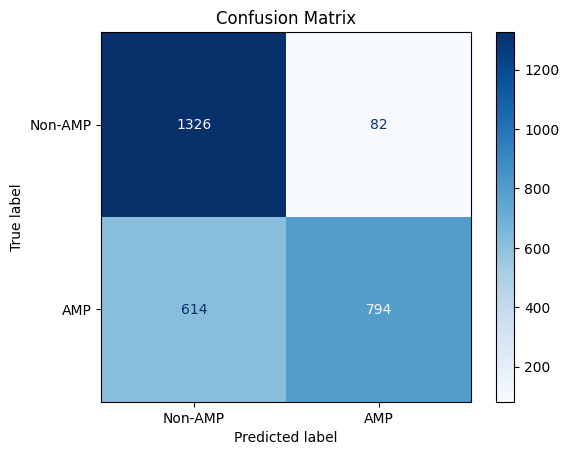

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions
predictions = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-AMP", "AMP"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
